In [1]:
#read images
import os
import cv2

car_images_path = os.getcwd()+'/vehicles'

cars = [os.path.join(dirpath, f)
    for dirpath, dirnames, files in os.walk(car_images_path)
    for f in files if f.endswith('.png')]

non_car_images_path = os.getcwd()+'/non-vehicles'

notcars = [os.path.join(dirpath, f)
    for dirpath, dirnames, files in os.walk(non_car_images_path)
    for f in files if f.endswith('.png')]
print('check kernel')

check kernel


In [2]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog

import pickle
#from lesson_functions import *
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
# from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split

# Define a function that takes an image,
# start and stop positions in both x and y,
# window size (x and y dimensions),
# and overlap fraction (for both x and y)
def slide_windows(x_start_stop=[None, None], y_start_stop=[None, None],
                 xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    window_list = []
    if xy_window[0] <= 0 or xy_window[1] <= 0:
        return window_list
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = 1280
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = 720
    # Compute the span of the region to be searched
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0] * (1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1] * (1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_windows = np.int(xspan / nx_pix_per_step) - 1
    ny_windows = np.int(yspan / ny_pix_per_step) - 1
    # Initialize a list to append window positions to

    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs * nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            if endx > x_start_stop[1]:
                break
            starty = ys * ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            if endy > y_start_stop[1]:
                break

            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

In [621]:
import math
class Box:
    def __init__(self,box):
        self.startX = box[0][0]
        self.startY = box[0][1]
        self.endX = box[1][0]
        self.endY = box[1][1]
        self.center = self.calculate_center()
        self.width = box[1][0] - box[0][0]
        self.height = box[1][1] - box[0][1]
        self.heat = 0

    def __delitem__(self, key):
        self.__delattr__(key)

    def __getitem__(self, key):
        if key == 0:
            return (self.__getattribute__('startX'),self.__getattribute__('startY'))
        elif key == 1:
            return (self.__getattribute__('endX'),self.__getattribute__('endY'))

    def calculate_center(self):
        return ((self.startX+self.endX)/2. ,(self.startY+self.endY)/2.)

    def calculate_distance(self,other):
        return math.sqrt((self.center[0] - other.center[0])**2+(self.center[1] - other.center[1])**2)

    def isEqual(self,other):
        return  self.close(other) & (abs(self.width - other.width) < 40) & (abs(self.height - other.height) < 20)

    def close(self,other):
        return (self.calculate_distance(other) < 1000)
    def printCords(self):
        print('startX  :', self.startX , ' ,startY  :', self.startY , ' ,endX  :', self.endX , ' ,endY  :', self.endY )

    def merge(self,other):
        #new_center = [0,0]
        #new_center[0] = (self.center[0]*self.heat + other.center[0]*other.heat)/2.
        #new_center[1] = (self.center[1]*self.heat + other.center[1]*other.heat)/2.
        sum_heat =  (self.heat + other.heat)
        self.startX = int((self.startX*self.heat + other.startX*other.heat)/(sum_heat*1.01))
        self.startY = int((self.startY*self.heat + other.startY*other.heat)/(sum_heat*1.01))
        self.endX = int((self.endX*self.heat + other.endX*other.heat)/(sum_heat*0.99))
        self.endY = int((self.endY*self.heat + other.endY*other.heat)/(sum_heat*0.99))
        self.center = self.calculate_center()
        self.width = self.endX - self.startX
        self.height = self.endY - self.startY
        self.heat = sum_heat/2.
        del other

    def _print(self):
        print('center  :', self.center , ' widht : ',self.width , ' height : ', self.height , ' heat : ', self.heat)
# Define a function you will pass an image
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB',
                    spatial_size=(32, 32), hist_bins=32,
                    hist_range=(0, 256), orient=9,
                    pix_per_cell=8, cell_per_block=2,
                    hog_channel=0, spatial_feat=True,
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space,
                            spatial_size=spatial_size, hist_bins=hist_bins,
                            orient=orient, pix_per_cell=pix_per_cell,
                            cell_per_block=cell_per_block,
                            hog_channel=hog_channel, spatial_feat=spatial_feat,
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows


    # Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes 2
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy


class VehicleDetector:
    old_positions = [] # positions of detectefd vehicles on the last frame
    car_list = []
    probablities = []
    svc = None
    X_scaler = None
    parameters = None
    debug = True
    def __init__(self,image):
        self.heat = np.zeros_like(image[:,:,0]).astype(np.float)
        self.image = image
        self.search_windows = []
        self.create_search_windows()
        self.load_cls_params()

    def load_cls_params(self):
        with open('models/linear_svc.p', 'rb') as model_file:
            model = pickle.load(model_file)
            self.svc = model['svc']
            self.X_scaler = model['X_scaler']
            self.parameters = model['parameters']

    #update feature parametrs and save on disk
    def update_parameters(self):
        color_space = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
        orient = 9
        pix_per_cell = 8
        cell_per_block = 2
        hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
        spatial_size = (16, 16)
        hist_bins = 32
        spatial_feat = True
        hist_feat = True
        hog_feat = True
        parameters = { 'color_space' : color_space,
            'orient': orient ,
            'pix_per_cell': pix_per_cell,
            'cell_per_block':cell_per_block,
            'hog_channel':hog_channel,
            'hist_bins':hist_bins,
            'spatial_feat':spatial_feat,
            'hist_feat':hist_feat,
            'hog_feat':hog_feat,
            'spatial_size':spatial_size }

        with open('models/linear_svc.p', 'wb') as model_file:
            pickle.dump({'svc': self.svc,'X_scaler': self.X_scaler,'parameters': parameters},model_file,pickle.HIGHEST_PROTOCOL)

    def age_heat_map(self):
        nonzero = self.heat.nonzero()
        self.heat[nonzero]-=1


    def create_search_windows(self):
        index = 1
        x_q = int(image.shape[1]/4)
        # split x into 3 region 0:width/4 , withd/4: 3*width/4 , 3*width/4:width
        for startx in range(0, self.image.shape[1] ,x_q):
            self.search_windows += slide_window(self.image, x_start_stop=[startx, startx+x_q], y_start_stop=[400, 500],
                            xy_window=(80*int(index/2), 80), xy_overlap=(0.75, 0.75))
            self.search_windows += slide_window(self.image, x_start_stop=[startx, startx+x_q], y_start_stop=[400, 500],
                                xy_window=(100*int(index/2), 100), xy_overlap=(0.75, 0.75))
            self.search_windows += slide_window(self.image, x_start_stop=[startx, startx+x_q], y_start_stop=[420, 660],
                                xy_window=(120*int(index/2), 120), xy_overlap=(0.5, 0.5))
            self.search_windows += slide_window(self.image, x_start_stop=[startx, startx+x_q], y_start_stop=[500, 690],
                                    xy_window=(160*int(index/2), 160), xy_overlap=(0.5, 0.5))
            index +=1

    def create_heatmap(self, bbox_list):
        heatmap = np.zeros_like(self.image[:,:,0]).astype(np.float)
        for box in bbox_list:
            # Add += 1 for all pixels inside each bbox
            # Assuming each "box" takes the form ((x1, y1), (x2, y2))
            self.heat[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1



    def apply_threshold(heatmap, threshold):
        # Zero out pixels below the threshold
        heatmap[heatmap <= threshold] = 0
        # Return thresholded map
        return heatmap

    #locate vehicles in the new frame
    def locate_vehicles(self):
        # Iterate through all detected cars
        self.heat[self.heat <= 2.5] = 0
        #heatmap = np.clip(self.heat, 0, 255)
        labels = label(self.heat)
        self.car_list = []
        for car_number in range(1, labels[1]+1):
            # Find pixels with each car_number label value
            nonzero = (labels[0] == car_number).nonzero()
            # Identify x and y values of those pixels
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            # Define a bounding box based on min/max x and y

            bbox = Box(((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy))))
            bbox.heat = self.heat[bbox.center[1]][bbox.center[0]]

            
            
            #for pos in self.old_positions:
            #    if pos.isEqual(bbox):
            #        self.old_positions.remove(pos)
            #        bbox.merge(pos)
            #        bbox.heat+=1

            self.car_list.append(bbox)
        #for pos in car_list:
        #    self.old_positions.append(pos)
        #print( ' 3 print(len(self.old_positions)) : ' , len(self.old_positions))
    def search_vehicles(self,image):

        # Uncomment the following line if you extracted training
        # data from .png images (scaled 0 to 1 by mpimg) and the
        # image you are searching is a .jpg (scaled 0 to 255)

        hot_windows = search_windows(image/255., self.search_windows, self.svc,
                                    self.X_scaler, color_space=self.parameters['color_space'],
                                    spatial_size=self.parameters['spatial_size'],
                                     hist_bins=self.parameters['hist_bins'],
                                    orient=self.parameters['orient'],
                                     pix_per_cell=self.parameters['pix_per_cell'],
                                    cell_per_block=self.parameters['cell_per_block'],
                                    hog_channel=self.parameters['hog_channel'],
                                     spatial_feat=self.parameters['spatial_feat'],
                                    hist_feat=self.parameters['hist_feat'],
                                     hog_feat=self.parameters['hog_feat'])
        #window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)
        self.create_heatmap(hot_windows)
        
        # Find final boxes from heatmap using label function
        self.locate_vehicles()
        #self.age_heat_map()
        print('hot_windows : ',len(hot_windows))
        draw_image = draw_boxes(image,self.car_list)
        plt.imshow(self.heat)
        plt.show()
        return draw_image

hot_windows :  6


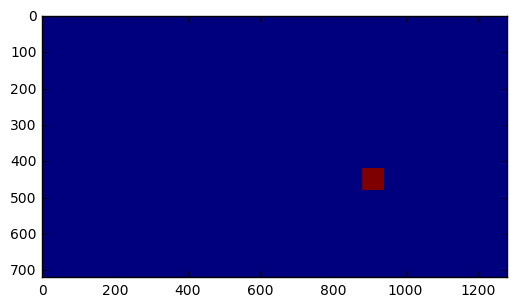

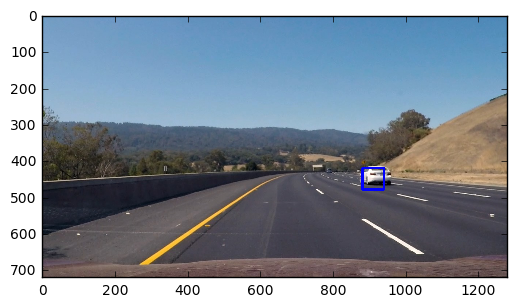

hot_windows :  6


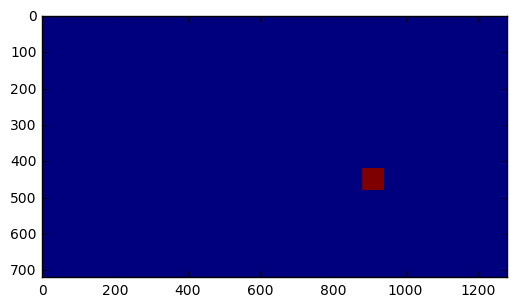

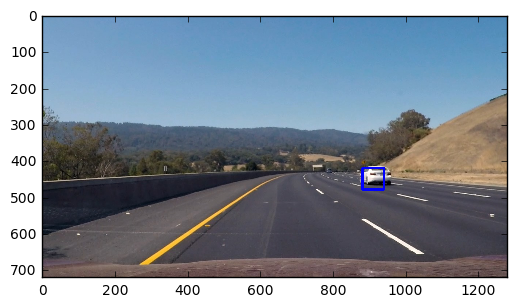

hot_windows :  6


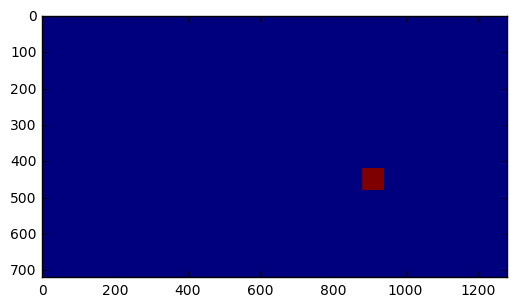

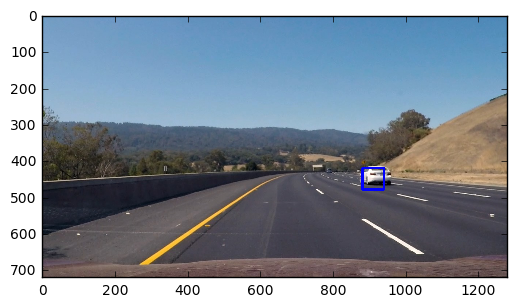

hot_windows :  6


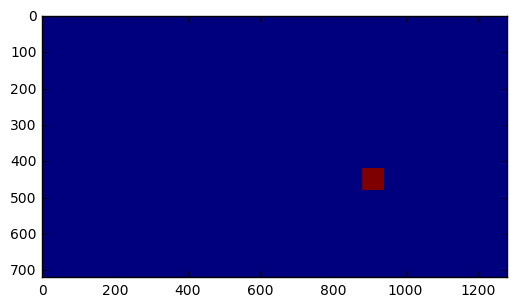

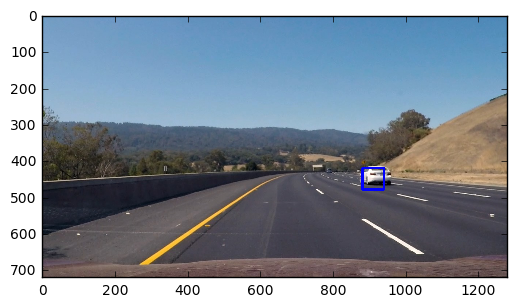

hot_windows :  8


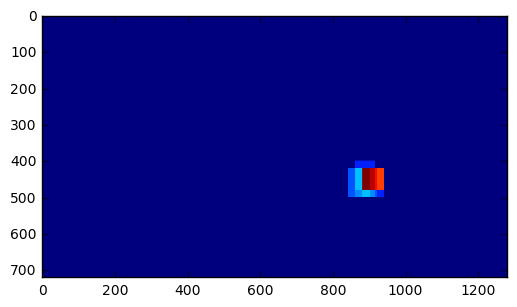

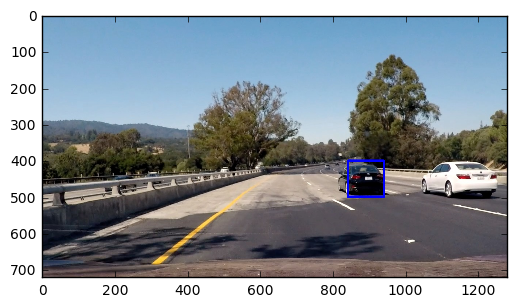

hot_windows :  20


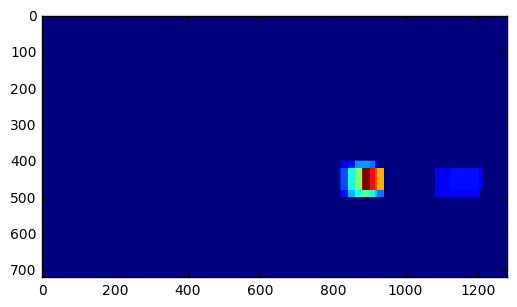

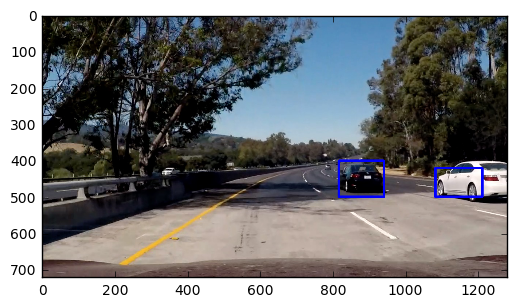

hot_windows :  14


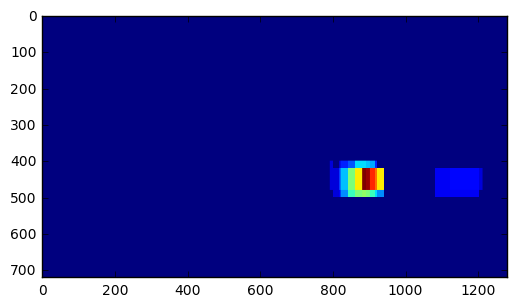

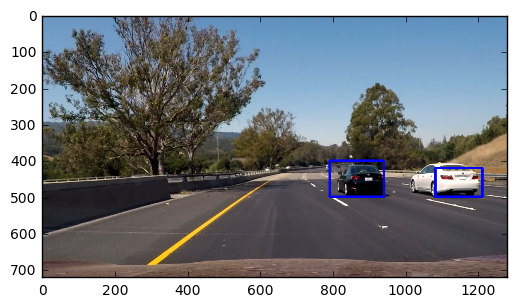

hot_windows :  14


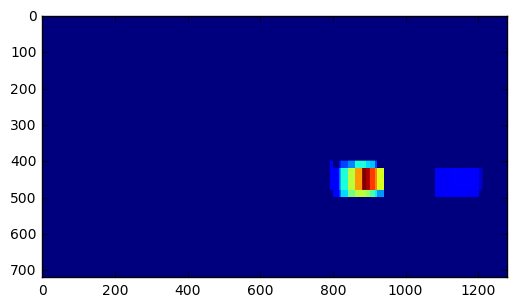

hot_windows :  14


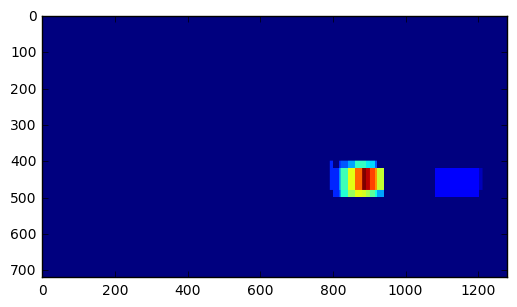

hot_windows :  14


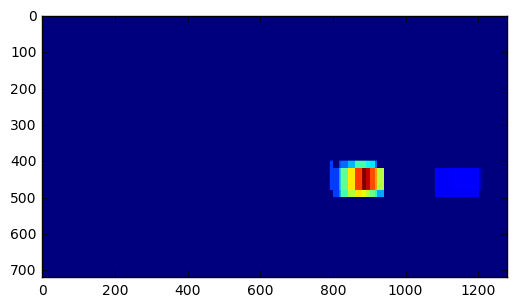

hot_windows :  14


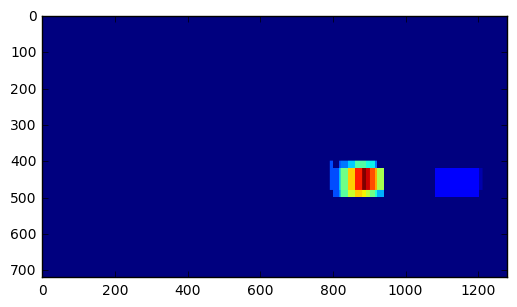

hot_windows :  14


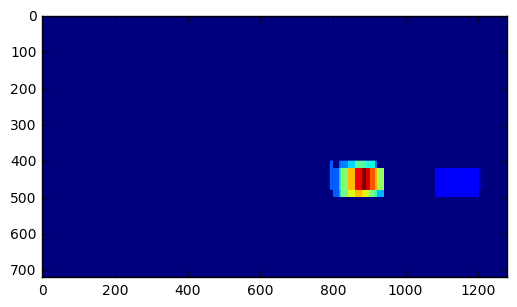

hot_windows :  6


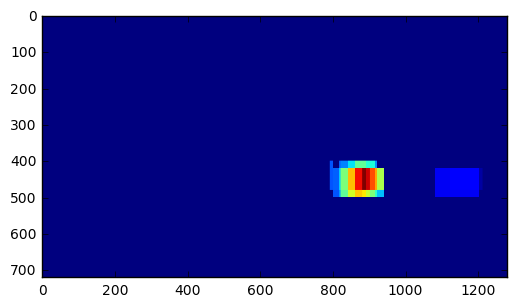

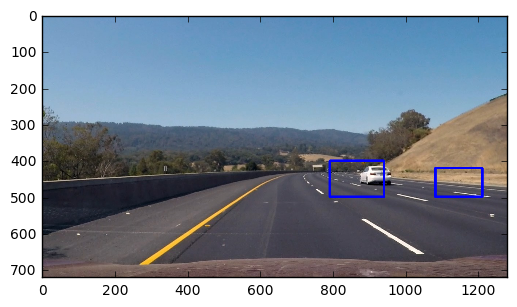

hot_windows :  6


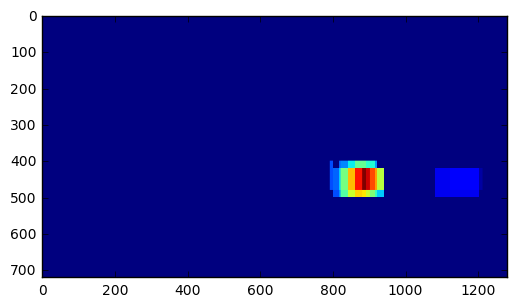

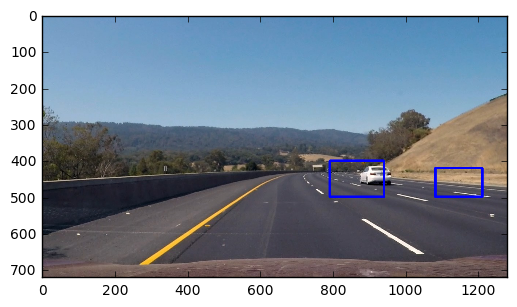

3.62 procesing time ...


In [622]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

image3 = mpimg.imread('test_images/test3.jpg')
image4 = mpimg.imread('test_images/test4.jpg')
image5 = mpimg.imread('test_images/test5.jpg')
image6 = mpimg.imread('test_images/test6.jpg')
v = VehicleDetector(image)
plt.imshow(v.search_vehicles(image3))
plt.show()
plt.imshow(v.search_vehicles(image3))
plt.show()
plt.imshow(v.search_vehicles(image3))
plt.show()
plt.imshow(v.search_vehicles(image3))
plt.show()
plt.imshow(v.search_vehicles(image4))
plt.show()
plt.imshow(v.search_vehicles(image5))
plt.show()
plt.imshow(v.search_vehicles(image6))
plt.show()
t=time.time()
v.search_vehicles(image6)
v.search_vehicles(image6)
v.search_vehicles(image6)
v.search_vehicles(image6)
v.search_vehicles(image6)
t2 = time.time()
plt.imshow(v.search_vehicles(image3))
plt.show()
plt.imshow(v.search_vehicles(image3))
plt.show()
print(round(t2-t, 2), 'procesing time ...')

In [2]:
import matplotlib.image as mpimg
from skimage.feature import hog
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
from scipy.ndimage.measurements import label

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block,
                     vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient,
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  transform_sqrt=True,
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:
        features = hog(img, orientations=orient,
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block),
                       transform_sqrt=True,
                       visualise=vis, feature_vector=feature_vec)
        return features


# Define a function to compute binned color features
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel()
    # Return the feature vector
    return features


# Define a function to compute color histogram features
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:, :, 0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:, :, 1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:, :, 2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                     hist_bins=32, orient=9,
                     pix_per_cell=8, cell_per_block=2, hog_channel=0,
                     spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else:
            feature_image = np.copy(image)

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
            # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:, :, channel],
                                                         orient, pix_per_cell, cell_per_block,
                                                         vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)
            else:
                hog_features = get_hog_features(feature_image[:, :, hog_channel], orient,
                                                pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features


# Define a function that takes an image,
# start and stop positions in both x and y,
# window size (x and y dimensions),
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None],
                 xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    window_list = []
    if xy_window[0] <= 0 or xy_window[1] <= 0:
        return window_list
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0] * (1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1] * (1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_windows = np.int(xspan / nx_pix_per_step) - 1
    ny_windows = np.int(yspan / ny_pix_per_step) - 1
    # Initialize a list to append window positions to

    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs * nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            if endx > x_start_stop[1]:
                break
            starty = ys * ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            if endy > y_start_stop[1]:
                break

            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

In [420]:
### TODO: Tweak these parameters and see how the results change.
color_space = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16)
hist_bins = 32
spatial_feat = True
hist_feat = True
hog_feat = True
y_start_stop = [400, 690] # Min and max in y to search in slide_window()

parameters = { 'color_space' : color_space,
               'orient': orient ,
               'pix_per_cell': pix_per_cell,
               'cell_per_block':cell_per_block,
               'hog_channel':hog_channel,
               'hist_bins':hist_bins,
               'spatial_feat':spatial_feat,
               'hist_feat':hist_feat,
               'hog_feat':hog_feat,
               'spatial_size':spatial_size }  
    
if False:
    t=time.time()
    car_features = extract_features(cars, color_space=color_space,
                        spatial_size=spatial_size, hist_bins=hist_bins,
                        orient=orient, pix_per_cell=pix_per_cell,
                        cell_per_block=cell_per_block,
                        hog_channel=hog_channel, spatial_feat=spatial_feat,
                        hist_feat=hist_feat, hog_feat=hog_feat)
    notcar_features = extract_features(notcars, color_space=color_space,
                        spatial_size=spatial_size, hist_bins=hist_bins,
                        orient=orient, pix_per_cell=pix_per_cell,
                        cell_per_block=cell_per_block,
                        hog_channel=hog_channel, spatial_feat=spatial_feat,
                        hist_feat=hist_feat, hog_feat=hog_feat)

    X = np.vstack((car_features, notcar_features)).astype(np.float64)
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)

    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

    print('Using:',orient,'orientations',pix_per_cell,
        'pixels per cell and', cell_per_block,'cells per block')
    print('Feature vector length:', len(X_train[0]))
    # Use a linear SVC
    svc = LinearSVC(max_iter=20000)
    # Check the training time for the SVC

    svc.fit(X_train, y_train)
    t2 = time.time()
    print(round(t2-t, 2), 'Total time for training...')
    # Check the score of the SVC
    print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
    # Check the prediction time for a single sample
    t=time.time()
    model_path = 'models/linear_svc.p'
    with open(model_path, 'wb') as model_file:
        pickle.dump({'svc': svc,'X_scaler': X_scaler,'parameters': parameters},model_file,pickle.HIGHEST_PROTOCOL)
else :
    with open('models/RGB/linear_svc.p', 'rb') as model_file:
        model = pickle.load(model_file)
        svc = model['svc']
        X_scaler = model['X_scaler']
        parameters = model['parameters']

windows len :  126


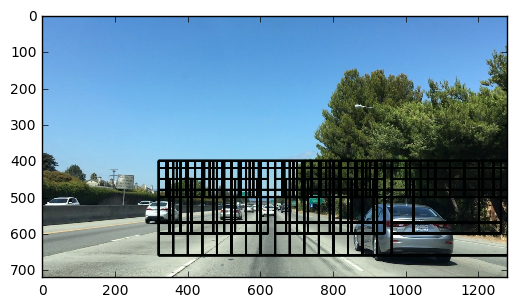

end of plot : 


In [122]:
image = mpimg.imread('test_images/test1.jpg')
draw_image = np.copy(image)

# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
#image = image.astype(np.float32)/255
t=time.time()


import glob
images = glob.glob('test_images/*.jpg')
for image_path in images:
    image = mpimg.imread(image_path)
    image = image.astype(np.float32)/255.0
    
    
    draw_image = np.copy(image)
    windows = []
    index = 1
    x_q = int(image.shape[1]/4)
    # split x into 3 region 0:width/4 , withd/4: 3*width/4 , 3*width/4:width
    for startx in range(0, image.shape[1] ,x_q):
        windows += slide_window(image, x_start_stop=[startx, startx+x_q], y_start_stop=[400, 500],
                        xy_window=(80*int(index/2), 80), xy_overlap=(0.75, 0.75))
        windows += slide_window(image, x_start_stop=[startx, startx+x_q], y_start_stop=[400, 500],
                            xy_window=(100*int(index/2), 100), xy_overlap=(0.75, 0.75))
        windows += slide_window(image, x_start_stop=[startx, startx+x_q], y_start_stop=[420, 660],
                            xy_window=(120*int(index/2), 120), xy_overlap=(0.75, 0.75))
        windows += slide_window(image, x_start_stop=[startx, startx+x_q], y_start_stop=[500, 690],
                                xy_window=(160*int(index/2), 160), xy_overlap=(0.75, 0.75))
        index +=1
    print('windows len : ',len(windows))
    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space,
                            spatial_size=spatial_size, hist_bins=hist_bins,
                            orient=orient, pix_per_cell=pix_per_cell,
                            cell_per_block=cell_per_block,
                            hog_channel=hog_channel, spatial_feat=spatial_feat,
                            hist_feat=hist_feat, hog_feat=hog_feat)
    window_img = draw_boxes(draw_image, windows, color=(0, 255, 255), thick=6)
    plt.imshow(window_img)
    plt.show()
    break
print('end of plot : ')

In [584]:
windows = []
index = 1
x_q = int(image.shape[1]/4)
# split x into 3 region 0:width/4 , withd/4: 3*width/4 , 3*width/4:width
for startx in range(0, image.shape[1] ,x_q):
    windows += slide_window(image, x_start_stop=[startx, startx+x_q], y_start_stop=[400, 500],
                    xy_window=(80*int(index/2), 80), xy_overlap=(0.75, 0.75))
    windows += slide_window(image, x_start_stop=[startx, startx+x_q], y_start_stop=[400, 500],
                        xy_window=(100*int(index/2), 100), xy_overlap=(0.75, 0.75))
    windows += slide_window(image, x_start_stop=[startx, startx+x_q], y_start_stop=[420, 660],
                        xy_window=(120*int(index/2), 120), xy_overlap=(0.5, 0.5))
    windows += slide_window(image, x_start_stop=[startx, startx+x_q], y_start_stop=[500, 690],
                            xy_window=(160*int(index/2), 160), xy_overlap=(0.5, 0.5))
    index +=1

def process_image2(image):
    t=time.time()
    draw_image = np.copy(image)
    

    # Uncomment the following line if you extracted training
    # data from .png images (scaled 0 to 1 by mpimg) and the
    # image you are searching is a .jpg (scaled 0 to 255)


    hot_windows = search_windows(image/255., windows, svc, X_scaler, color_space=color_space,
                            spatial_size=spatial_size, hist_bins=hist_bins,
                            orient=orient, pix_per_cell=pix_per_cell,
                            cell_per_block=cell_per_block,
                            hog_channel=hog_channel, spatial_feat=spatial_feat,
                            hist_feat=hist_feat, hog_feat=hog_feat)

    #window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)
    
    t2 = time.time()
    print(round(t2-t, 2), 'procesing time ...')
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat,hot_windows)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1)

    # Visualize the heatmap when displaying
    heatmap = np.clip(heat, 0, 255)
    #plt.imshow(heatmap)
    #plt.show()
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_image = draw_labeled_bboxes(image, labels) #draw_boxes (np.copy(image),windows)
    return draw_image

In [92]:
import glob

images = glob.glob('test_images/*.jpeg')
for image_path in images:
    image = mpimg.imread(image_path)
    draw_image = process_image(image)
    fig = plt.figure()
    plt.subplot(121)
    plt.imshow(image)
    plt.title('Car Positions')
    plt.subplot(122)
    plt.imshow(draw_image, cmap='hot')
    plt.title('Heat Map')
    fig.tight_layout()
    plt.show()

0.51 procesing time ...


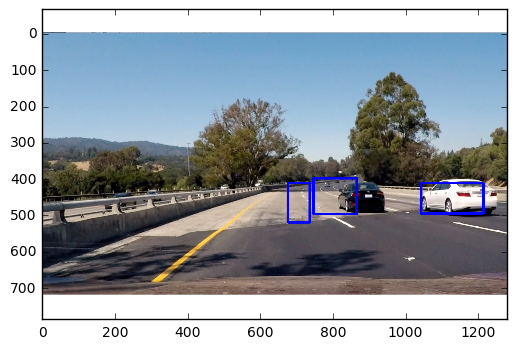

1280


In [93]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
image = mpimg.imread('test_images/test4.jpg')
mean = [0, 0]
cov = [[1280, 0], [0, 720]]  # diagonal covariance
x, y = np.random.multivariate_normal(mean, cov, 128*72).T
#plt.plot(x, y, 'x')
plt.axis('equal')
t=time.time()
processed_iamge = process_image(image)
t2 = time.time()
print(round(t2-t, 2), 'procesing time ...')
plt.imshow(processed_iamge)
#plt.grid(color='b', linestyle='-', linewidth=2)
plt.show()
print(image.shape[1])

C:\Users\burak.topal\Desktop\Triodor\burak\udacity\CarND-Vehicle-Detection\tryouts


C:\Users\burak.topal\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:282: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


0.59 procesing time ...
Numer Of Cars = in old frame :  0
Numer Of Cars = in new frame :  2


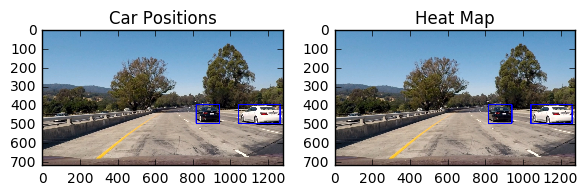

center  : (877.0, 449.5)  widht :  124  height :  99  heat :  9.0
center  : (1149.5, 449.5)  widht :  219  height :  99  heat :  6.0
0.5 procesing time ...
Numer Of Cars = in old frame :  2
Numer Of Cars = in new frame :  0


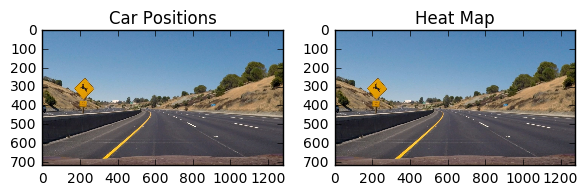

0.52 procesing time ...
Numer Of Cars = in old frame :  0
Numer Of Cars = in new frame :  1


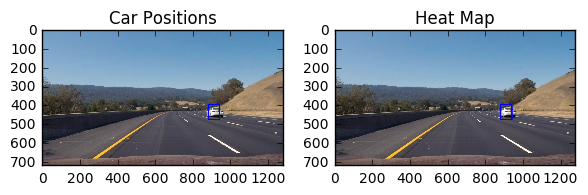

center  : (909.5, 439.5)  widht :  59  height :  79  heat :  2.0
0.54 procesing time ...
Numer Of Cars = in old frame :  1
Numer Of Cars = in new frame :  2


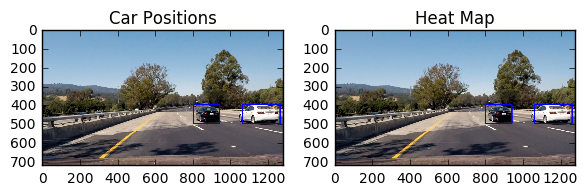

center  : (869.5, 449.5)  widht :  139  height :  99  heat :  10.0
center  : (1159.5, 449.5)  widht :  199  height :  99  heat :  4.0
0.66 procesing time ...
Numer Of Cars = in old frame :  2
Numer Of Cars = in new frame :  4


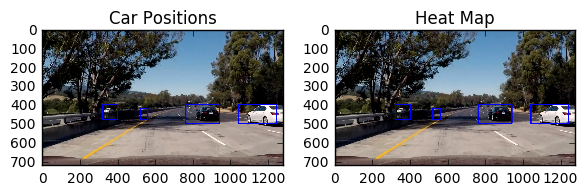

center  : (359.5, 439.5)  widht :  79  height :  79  heat :  2.0
center  : (849.5, 449.5)  widht :  179  height :  99  heat :  9.0
center  : (1139.5, 449.5)  widht :  199  height :  99  heat :  6.0
center  : (539.5, 449.5)  widht :  39  height :  59  heat :  2.0
0.52 procesing time ...
Numer Of Cars = in old frame :  4
Numer Of Cars = in new frame :  2


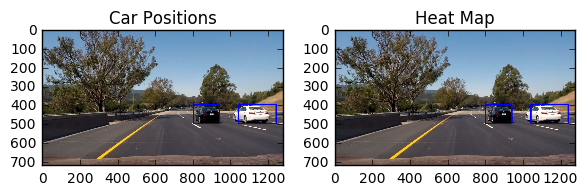

In [4]:
import math
import matplotlib.pyplot as plt
import time
from lesson_functions import *
import pickle
from scipy.ndimage.measurements import label
import cv2

class Box:
    def __init__(self, box):
        self.startX = box[0][0]
        self.startY = box[0][1]
        self.endX = box[1][0]
        self.endY = box[1][1]
        self.center = self.calculate_center()
        self.width = box[1][0] - box[0][0]
        self.height = box[1][1] - box[0][1]
        self.heat = 0

    def __delitem__(self, key):
        self.__delattr__(key)

    def __getitem__(self, key):
        if key == 0:
            return (self.__getattribute__('startX'), self.__getattribute__('startY'))
        elif key == 1:
            return (self.__getattribute__('endX'), self.__getattribute__('endY'))

    def calculate_center(self):
        return ((self.startX + self.endX) / 2., (self.startY + self.endY) / 2.)

    def calculate_distance(self, other):
        return math.sqrt((self.center[0] - other.center[0]) ** 2 + (self.center[1] - other.center[1]) ** 2)

    def isEqual(self, other):
        return self.close(other) & (abs(self.width - other.width) < 40) & (abs(self.height - other.height) < 20)

    def close(self, other):
        return (self.calculate_distance(other) < 1000)

    def printCords(self):
        print('startX  :', self.startX, ' ,startY  :', self.startY, ' ,endX  :', self.endX, ' ,endY  :', self.endY)

    def merge(self, other):
        # new_center = [0,0]
        # new_center[0] = (self.center[0]*self.heat + other.center[0]*other.heat)/2.
        # new_center[1] = (self.center[1]*self.heat + other.center[1]*other.heat)/2.
        sum_heat = (self.heat + other.heat)
        self.startX = int((self.startX * self.heat + other.startX * other.heat) / (sum_heat * 1.01))
        self.startY = int((self.startY * self.heat + other.startY * other.heat) / (sum_heat * 1.01))
        self.endX = int((self.endX * self.heat + other.endX * other.heat) / (sum_heat * 0.99))
        self.endY = int((self.endY * self.heat + other.endY * other.heat) / (sum_heat * 0.99))
        self.center = self.calculate_center()
        self.width = self.endX - self.startX
        self.height = self.endY - self.startY
        self.heat = sum_heat / 2.
        del other

    def _print(self):
        print('center  :', self.center, ' widht : ', self.width, ' height : ', self.height, ' heat : ', self.heat)


# Define a function you will pass an image
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB',
                   spatial_size=(32, 32), hist_bins=32,
                   hist_range=(0, 256), orient=9,
                   pix_per_cell=8, cell_per_block=2,
                   hog_channel=0, spatial_feat=True,
                   hist_feat=True, hog_feat=True):
    # 1) Create an empty list to receive positive detection windows
    on_windows = []
    # 2) Iterate over all windows in the list
    for window in windows:
        # 3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
        # 4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space,
                                       spatial_size=spatial_size, hist_bins=hist_bins,
                                       orient=orient, pix_per_cell=pix_per_cell,
                                       cell_per_block=cell_per_block,
                                       hog_channel=hog_channel, spatial_feat=spatial_feat,
                                       hist_feat=hist_feat, hog_feat=hog_feat)
        # 5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        # 6) Predict using your classifier
        prediction = clf.predict(test_features)
        # 7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    # 8) Return windows for positive detections
    return on_windows


    # Define a function to draw bounding boxes


def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes 2
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy


class VehicleDetector:
    old_positions = []  # positions of detectefd vehicles on the last frame
    car_list = []
    probablities = []
    svc = None
    X_scaler = None
    parameters = None
    debug = True
    image_shape = (720,1280)
    def __init__(self, image):
        self.heat = np.zeros_like(image[:, :, 0]).astype(np.float)
        self.image = image
        self.search_windows = []
        self.create_search_windows()
        self.load_cls_params()

    def load_cls_params(self):
        with open('../models/linear_svc.p', 'rb') as model_file:
            model = pickle.load(model_file)
            self.svc = model['svc']
            self.X_scaler = model['X_scaler']
            self.parameters = model['parameters']

    def age_heat_map(self):
        nonzero = self.heat.nonzero()
        self.heat[nonzero] -= 1

    def create_search_windows(self):
        index = 1
        x_q = int(self.image.shape[1] / 4)
        # split x into 3 region 0:width/4 , withd/4: 3*width/4 , 3*width/4:width
        for startx in range(0, self.image.shape[1], x_q):
            self.search_windows += slide_window(self.image, x_start_stop=[startx, startx + x_q],
                                                y_start_stop=[400, 500],
                                                xy_window=(80 * int(index / 2), 80), xy_overlap=(0.75, 0.75))
            self.search_windows += slide_window(self.image, x_start_stop=[startx, startx + x_q],
                                                y_start_stop=[400, 500],
                                                xy_window=(100 * int(index / 2), 100), xy_overlap=(0.75, 0.75))
            self.search_windows += slide_window(self.image, x_start_stop=[startx, startx + x_q],
                                                y_start_stop=[420, 660],
                                                xy_window=(120 * int(index / 2), 120), xy_overlap=(0.5, 0.5))
            self.search_windows += slide_window(self.image, x_start_stop=[startx, startx + x_q],
                                                y_start_stop=[500, 690],
                                                xy_window=(160 * int(index / 2), 160), xy_overlap=(0.5, 0.5))
            index += 1

    def create_heatmap(self, bbox_list):
        heatmap = np.zeros_like(self.image[:, :, 0]).astype(np.float)
        for box in bbox_list:
            # Add += 1 for all pixels inside each bbox
            # Assuming each "box" takes the form ((x1, y1), (x2, y2))
            self.heat[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    def apply_threshold(heatmap, threshold):
        # Zero out pixels below the threshold
        heatmap[heatmap <= threshold] = 0
        # Return thresholded map
        return heatmap

    # locate vehicles in the new frame
    def locate_vehicles(self):
        # Iterate through all detected cars
        self.heat[self.heat <= 1] = 0
        # heatmap = np.clip(self.heat, 0, 255)
        labels = label(self.heat)
        self.car_list = []
        for car_number in range(1, labels[1] + 1):
            # Find pixels with each car_number label value
            nonzero = (labels[0] == car_number).nonzero()
            # Identify x and y values of those pixels
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            # Define a bounding box based on min/max x and y

            bbox = Box(((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy))))
            bbox.heat = self.heat[bbox.center[1]][bbox.center[0]]

            for pos in self.old_positions:
                if pos.isEqual(bbox):
                    self.old_positions.remove(pos)
                    bbox.merge(pos)
                    bbox.heat+=1

            self.car_list.append(bbox)
            # for pos in car_list:
            #    self.old_positions.append(pos)
            # print( ' 3 print(len(self.old_positions)) : ' , len(self.old_positions))

    def search_vehicles(self, image):

        # Uncomment the following line if you extracted training
        # data from .png images (scaled 0 to 1 by mpimg) and the
        # image you are searching is a .jpg (scaled 0 to 255)
        image = image.astype(np.float32) / 255.
        hot_windows = search_windows(image, self.search_windows, self.svc,
                                     self.X_scaler, color_space=self.parameters['color_space'],
                                     spatial_size=self.parameters['spatial_size'],
                                     hist_bins=self.parameters['hist_bins'],
                                     orient=self.parameters['orient'],
                                     pix_per_cell=self.parameters['pix_per_cell'],
                                     cell_per_block=self.parameters['cell_per_block'],
                                     hog_channel=self.parameters['hog_channel'],
                                     spatial_feat=self.parameters['spatial_feat'],
                                     hist_feat=self.parameters['hist_feat'],
                                     hog_feat=self.parameters['hog_feat'])
        # window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)
        self.create_heatmap(hot_windows)

        # Find final boxes from heatmap using label function
        self.locate_vehicles()
        # self.age_heat_map()
        print('hot_windows : ', len(hot_windows))
        draw_image = draw_boxes(image, self.car_list)
        return draw_image
import os 
print(os.getcwd())
image = mpimg.imread('../test_images/test1.jpg')

vehicleDetertor = VehicleDetector(image)
import glob


def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap  # Iterate through list of bboxes


def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap


def draw_labeled_bboxes(img,labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1] + 1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0, 0, 255), 6)
    # Return the image
    return img

def locate_cars(img,image):
    # Iterate through all detected cars
    # Find final boxes from heatmap using label function
    add_heat(img,vehicleDetertor.old_positions)
    apply_threshold(img,len(vehicleDetertor.old_positions)-1)
    for old_car in vehicleDetertor.old_positions:
        old_car._print()

    labels = label(img)
    car_list = []
    for car_number in range(1, labels[1] + 1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = Box(((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy))))
        bbox.heat = img[bbox.center[1]][bbox.center[0]]
        car_list.append(bbox)
        cv2.rectangle(image, bbox[0], bbox[1], (0, 0, 255), 6)

    # Return car list
    return car_list , image

def process_image(image):
    copy_image = np.copy(image)
    copy_image = copy_image.astype(np.float32) / 255.
    hot_windows = search_windows(copy_image, vehicleDetertor.search_windows, vehicleDetertor.svc,
                                 vehicleDetertor.X_scaler, color_space=vehicleDetertor.parameters['color_space'],
                                 spatial_size=vehicleDetertor.parameters['spatial_size'],
                                 hist_bins=vehicleDetertor.parameters['hist_bins'],
                                 orient=vehicleDetertor.parameters['orient'],
                                 pix_per_cell=vehicleDetertor.parameters['pix_per_cell'],
                                 cell_per_block=vehicleDetertor.parameters['cell_per_block'],
                                 hog_channel=vehicleDetertor.parameters['hog_channel'],
                                 spatial_feat=vehicleDetertor.parameters['spatial_feat'],
                                 hist_feat=vehicleDetertor.parameters['hist_feat'],
                                 hog_feat=vehicleDetertor.parameters['hog_feat'])
    heat = np.zeros_like(image[:, :, 0]).astype(np.float)
    add_heat(heat,hot_windows)
    apply_threshold(heat,1)
    # Visualize the heatmap when displaying
    #heatmap = np.clip(heat, 0, 255)
    draw_img = np.copy(image)
    vehicleDetertor.car_list,draw_img = locate_cars(heat,image)
    #labels = label(heat)

    return draw_img


#import os
#from moviepy.editor import VideoFileClip
#white_output = 'white.mp4' # New video
#os.remove(white_output)
#clip1 = VideoFileClip('project_video.mp4').subclip(38.00,45.00) # project video
#clip = VideoFileClip("myHolidays.mp4", audio=True).subclip(50,60)
#white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
#white_clip.write_videofile(white_output, audio=False)

images = glob.glob('../test_images/*.jpg')
for image_path in images:
    image = mpimg.imread(image_path)
    t = time.time()
    draw_image = process_image(image)
    t2 = time.time()
    print(round(t2 - t, 2), 'procesing time ...')
    print('Numer Of Cars = in old frame : ' , len(vehicleDetertor.old_positions))
    print('Numer Of Cars = in new frame : ', len(vehicleDetertor.car_list))
    vehicleDetertor.old_positions = vehicleDetertor.car_list
    fig = plt.figure()
    plt.subplot(121)
    plt.imshow(image)
    plt.title('Car Positions')
    plt.subplot(122)
    plt.imshow(draw_image, cmap='hot')
    plt.title('Heat Map')
    fig.tight_layout()
    plt.show()
    
del vehicleDetertor

In [5]:
vd = VehicleDetector(image)
def process_image5(image):
    return vd.search_vehicles(image)

def process_image6(image):
    return image
from moviepy.editor import VideoFileClip
white_output = 'white.mp4' # New video
clip1 = VideoFileClip('project_video.mp4') # project video
#clip = VideoFileClip("myHolidays.mp4", audio=True).subclip(50,60)
white_clip = clip1.fl_image(process_image5) #NOTE: this function expects color images!!
white_clip.write_videofile(white_output, audio=False)

ImportError: No module named 'moviepy'

In [559]:
from IPython.display import HTML
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [2]:
from moviepy.editor import VideoFileClip

ImportError: No module named 'moviepy'

{'color_space': 'YCrCb', 'hist_bins': 16, 'spatial_feat': True, 'hog_feat': True, 'hist_feat': True, 'orient': 8, 'cell_per_block': 2, 'pix_per_cell': 8, 'hog_channel': 'ALL', 'spatial_size': (16, 16)}


C:\Users\burak.topal\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:315: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


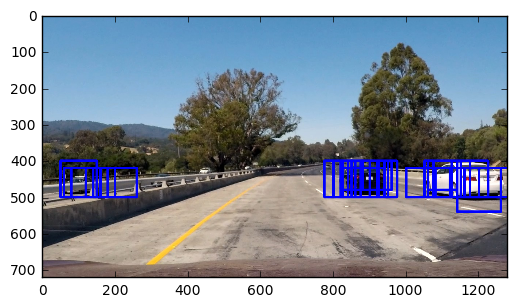

1.55 procesing time ...
Numer Of Cars = in old frame :  0
Numer Of Cars = in new frame :  4


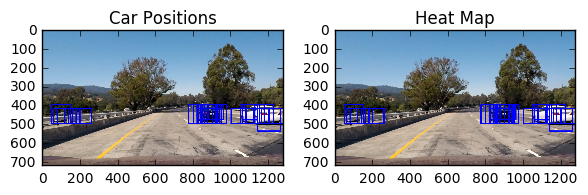

In [15]:
import math
import matplotlib.pyplot as plt
import time
from lesson_functions import *
import pickle
from scipy.ndimage.measurements import label


class Box:
    # Box class to represent and keep track of the cars on a video stream
    def __init__(self, box):
        # x1 coordinate of the box
        self.startX = box[0][0]
        # y1 coordinate of the box
        self.startY = box[0][1]
        # x2 coordinate of the box
        self.endX = box[1][0]
        # y2 coordinate of the box
        self.endY = box[1][1]
        # center (x,y) coordinte
        self.center = self.calculate_center()
        # width (x2-x1) length
        self.width = self.calculate_width()
        # height (y2-y1) length
        self.height = self.calculate_height()
        # heat of the box (represent
        self.heat = 0
        # speed vector in x-y pixel coordinates
        self.speed = [0, 0]
        # age to track and get rid of old boxes (vehicles detected and dragged along the video frames)
        self.age = 0

    def __getitem__(self, key):
        """
            Return the value of start or end points of the box
            :param key to select start or end point
        """
        if key == 0:
            return (self.__getattribute__('startX'), self.__getattribute__('startY'))
        elif key == 1:
            return (self.__getattribute__('endX'), self.__getattribute__('endY'))

    def calculate_center(self):
        """
            Calculates the center coordinates of the box
        """
        return [(self.startX + self.endX) / 2., (self.startY + self.endY) / 2.]

    def calculate_distance(self, other):
        """
            Calculates center to center distance to given box
            :param other box to calculate distance
        """
        return math.sqrt((self.center[0] - other.center[0]) ** 2 + (self.center[1] - other.center[1]) ** 2)

    def is_equal(self, other):
        """
            Checks if the given box has similar attributes
            :param other box to compare
        """
        return self.close(other) & (abs(self.width - other.width) < 100) & (abs(self.height - other.height) < 50)

    def close(self, other):
        """
            Checks if the given box is closer in a certain threhold
            :param other box to compare
        """
        return (self.calculate_distance(other) < 100)

    def calculate_width(self):
        """
            Calculates width of the box
        """
        return self.endX - self.startX

    def calculate_height(self):
        """
            Calculates height of the box
        """
        return self.endY - self.startY

    def print_cords(self):
        """
            Prints the x and y coorinates of the box
        """
        print('startX  :', self.startX, ' ,startY  :', self.startY, ' ,endX  :', self.endX, ' ,endY  :', self.endY)

    # def merge(self, other):
    #     # new_center = [0,0]
    #     # new_center[0] = (self.center[0]*self.heat + other.center[0]*other.heat)/2.
    #     # new_center[1] = (self.center[1]*self.heat + other.center[1]*other.heat)/2.
    #     sum_heat = (self.heat + other.heat)
    #     self.startX = int((self.startX * self.heat + other.startX * other.heat) / (sum_heat * 1.01))
    #     self.startY = int((self.startY * self.heat + other.startY * other.heat) / (sum_heat * 1.01))
    #     self.endX = int((self.endX * self.heat + other.endX * other.heat) / (sum_heat * 0.99))
    #     self.endY = int((self.endY * self.heat + other.endY * other.heat) / (sum_heat * 0.99))
    #     self.center = self.calculate_center()
    #     self.width = self.endX - self.startX
    #     self.height = self.endY - self.startY
    #     self.heat = sum_heat / 2.
    #     del other


    def calculate_speed(self, old):
        """
            Calculates the speed in xy pixel coordinate wtih respect to old position
            :param old box from the previous frame
        """
        self.speed[0] = self.center[0] - old.center[0]
        self.speed[1] = self.center[1] - old.center[1]

    def _print(self):
        """
            Prints the attributes of the box
        """
        print('center  :', self.center, ' widht : ', self.width, ' height : ', self.height, ' heat : ', self.heat,
              ' speed ', self.speed)


# Define a function you will pass an image
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='YCrCb',
                   spatial_size=(16, 16), hist_bins=16,
                   orient=8,
                   pix_per_cell=8, cell_per_block=2,
                   hog_channel='ALL', spatial_feat=True,
                   hist_feat=True, hog_feat=True):
    # 1) Create an empty list to receive positive detection windows
    on_windows = []
    # 2) Iterate over all windows in the list
    for window in windows:
        # 3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
        # 4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space,
                                       spatial_size=spatial_size, hist_bins=hist_bins,
                                       orient=orient, pix_per_cell=pix_per_cell,
                                       cell_per_block=cell_per_block,
                                       hog_channel=hog_channel, spatial_feat=spatial_feat,
                                       hist_feat=hist_feat, hog_feat=hog_feat)
        # 5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        # 6) Predict using your classifier
        prediction = clf.predict(test_features)
        # 7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    # 8) Return windows for positive detections
    return on_windows


    # Define a function to draw bounding boxes


class VehicleDetector:
    """
    Class to detect vehicles on video stream it
    :param old_positions list to keep track of the cars located on previous frames
    :param car_list list to keep located cars on current frame
    :param scv classifier to classify windows whether it is car or not
    :param X_scaler standart scaler for normalization
    :param parameters feature parameters
    :param debug flag to enable/disable  debugging
    :param ımage_shape shape of the image to be work on
    """
    old_positions = []  # positions of detectefd vehicles on the last frame
    car_list = []
    svc = None
    X_scaler = None
    parameters = None
    debug = True
    image_shape = (720, 1280)

    def __init__(self, image):
        self.heat = np.zeros_like(image[:, :, 0]).astype(np.float)
        self.image = image
        self.search_windows = []
        self.create_search_windows()
        self.load_cls_params()
        self.image_shape = image.shape

    def load_cls_params(self):
        """
        Method to load classifier, scaler and feature parameters from file
        """
        with open('../models/linear_svc.p', 'rb') as model_file:
            model = pickle.load(model_file)
            self.svc = model['svc']
            self.X_scaler = model['X_scaler']
            self.parameters = model['parameters']

        print(self.parameters)

    def age_heat_map(self):
        """
        Method to age old vehıcles by reducing heat
        """
        nonzero = self.heat.nonzero()
        self.heat[nonzero] -= 1

    def create_search_windows(self):
        self.search_windows += slide_window(self.image.shape, x_start_stop=[0, image.shape[1]],
                                            y_start_stop=[400, 500],
                                            xy_window=(80, 80), xy_overlap=(0.75, 0.75))
        self.search_windows += slide_window(self.image.shape, x_start_stop=[None, None],
                                            y_start_stop=[400, 500],
                                            xy_window=(100, 100), xy_overlap=(0.75, 0.75))
        self.search_windows += slide_window(self.image.shape, x_start_stop=[None, None],
                                            y_start_stop=[420, 660],
                                            xy_window=(120, 120), xy_overlap=(0.5, 0.5))
        self.search_windows += slide_window(self.image.shape, x_start_stop=[None, None],
                                            y_start_stop=[500, 690],
                                            xy_window=(160, 160), xy_overlap=(0.5, 0.5))

image = mpimg.imread('../test_images/test1.jpg')

vehicleDetertor = VehicleDetector(image)
import glob


def add_heat(heatmap, bbox_list):
    """
    Iterates through the box list and increment the value of the pixel for each box if the corresponding pixel is on the box
    """
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap


def apply_threshold(heatmap, threshold):
    """
    :param heatmap: previous heatmap to be updated
    :param threshold:
    :return: updated heatmap
    """
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap


def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes 2
    cars_N = len(bboxes)
    found_N = 0
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates


        if bbox.heat > 14 and bbox.age < 4:
            cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
            found_N +=1
            #this is for debugging
            font = cv2.FONT_HERSHEY_SIMPLEX
            age_text = "Age: {0:.2f} ".format(bbox.age)
            cv2.putText(imcopy, age_text, (int(bbox.center[0]), int(bbox.center[1])), font, 1, (255, 0, 0), 2)
            # speed_text = "Y Speed: {0:.2f} ".format(bbox.speed[1])
            # cv2.putText(imcopy, speed_text, (int(bbox.center[0]),int(bbox.center[1]+20)), font, 1, (255, 255, 255), 2)
    # Return the image copy with boxes drawn
    font = cv2.FONT_HERSHEY_SIMPLEX
    old_cars_text = "N of Cars: {0:.2f} ".format(cars_N)
    found_text =  "N of Found Cars: {0:.2f} ".format(found_N)
    cv2.putText(imcopy, old_cars_text, (10, 40), font, 1, (255, 255, 255), 2)
    cv2.putText(imcopy, found_text, (10,80), font, 1, (255, 255, 255), 2)
    return imcopy


def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1] + 1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0, 0, 255), 6)
    # Return the image
    return img

def draw_windows(img, windows):
    # Iterate through all detected cars
    for window in windows:

        cv2.rectangle(img, window[0], window[1], (0, 0, 255), 6)
    # Return the image
    return img


def locate_cars(img):
    # Iterate through all detected cars
    # Find final boxes from heatmap using label function
    # add_heat(img,vehicleDetertor.old_positions)
    # apply_threshold(img,len(vehicleDetertor.old_positions)-1)


    labels = label(img)
    car_list = []
    for car_number in range(1, labels[1] + 1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = Box(((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy))))
        bbox.heat = img[bbox.center[1]][bbox.center[0]]
        # if bbox.heat > 5:
        car_list.append(bbox)

    # Return car list

    for old_car in vehicleDetertor.old_positions:
        # print('old cars : ')
        # old_car._print()
        # print()
        found = False
        for car in car_list:
            # print('new cars : ')
            # car._print()
            if car.is_equal(old_car):
                # print('is  equal : ')
                car.calculate_speed(old_car)
                car.heat = max(car.heat, old_car.heat) + 1
                # to remove jittering we should apply a smoother
                car.width = 0.8*car.width + 0.2*old_car.width
                car.height = 0.8 * car.height + 0.2 * old_car.height
                found = True
                break

        if not found and old_car.heat > 5:# and old_car.age < 10:
            # print(' old car not found in the new frame but shoud be there :   ' ,old_car.heat)
            old_car.age += 1
            old_car.heat -= 1
            car_list.append(old_car)

            # print()
    return car_list

from multiprocessing import Pool
pool = Pool(4)
def process_image(image):
    copy_image = np.copy(image)
    copy_image = copy_image.astype(np.float32) / 255.
    '''
    A = (copy_image, vehicleDetertor.search_windows[0:50], vehicleDetertor.svc,
                                 vehicleDetertor.X_scaler)
    B = (copy_image, vehicleDetertor.search_windows[50:100], vehicleDetertor.svc,
                                 vehicleDetertor.X_scaler)

    C = (copy_image, vehicleDetertor.search_windows[100:150], vehicleDetertor.svc,
         vehicleDetertor.X_scaler)

    D = (copy_image, vehicleDetertor.search_windows[150:len(vehicleDetertor.search_windows)], vehicleDetertor.svc,
         vehicleDetertor.X_scaler)

    result1 = pool.apply_async(search_windows, A)  # evaluate "solve1(A)" asynchronously
    result2 = pool.apply_async(search_windows, B)  # evaluate "solve2(B)" asynchronously
    result3 = pool.apply_async(search_windows, C)  # evaluate "solve1(A)" asynchronously
    result4 = pool.apply_async(search_windows, D)  # evaluate "solve2(B)" asynchronously
    answer1 = result1.get(timeout=100)
    answer2 = result2.get(timeout=100)
    answer3 = result3.get(timeout=100)
    answer4 = result4.get(timeout=100)

    '''
    hot_windows = search_windows(copy_image, vehicleDetertor.search_windows, vehicleDetertor.svc,
                                 vehicleDetertor.X_scaler, color_space=vehicleDetertor.parameters['color_space'],
                                 spatial_size=vehicleDetertor.parameters['spatial_size'],
                                 hist_bins=vehicleDetertor.parameters['hist_bins'],
                                 orient=vehicleDetertor.parameters['orient'],
                                 pix_per_cell=vehicleDetertor.parameters['pix_per_cell'],
                                 cell_per_block=vehicleDetertor.parameters['cell_per_block'],
                                 hog_channel=vehicleDetertor.parameters['hog_channel'],
                                 spatial_feat=vehicleDetertor.parameters['spatial_feat'],
                                 hist_feat=vehicleDetertor.parameters['hist_feat'],
                                 hog_feat=vehicleDetertor.parameters['hog_feat'])
    '''
    hot_windows = answer1
    hot_windows += answer2
    hot_windows += answer3
    hot_windows += answer4
    '''
    heat = np.zeros_like(image[:, :, 0]).astype(np.float)
    add_heat(heat, hot_windows)
    apply_threshold(heat, 1)
    # Visualize the heatmap when displaying
    # heatmap = np.clip(heat, 0, 255)

    VehicleDetector.old_positions = vehicleDetertor.car_list
    vehicleDetertor.car_list = locate_cars(heat)

    # labels = label(heat)
    # draw_img = draw_labeled_bboxes(image,labels)
    draw_img = draw_windows(image, hot_windows)
    plt.imshow(draw_img)
    plt.show()
    return draw_img



image = mpimg.imread('../test_images/test1.jpg')
t = time.time()
draw_image = process_image(image)
t2 = time.time()
print(round(t2 - t, 2), 'procesing time ...')
print('Numer Of Cars = in old frame : ' , len(vehicleDetertor.old_positions))
print('Numer Of Cars = in new frame : ', len(vehicleDetertor.car_list))
vehicleDetertor.old_positions = vehicleDetertor.car_list
fig = plt.figure()
plt.subplot(121)
plt.imshow(image)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(draw_image, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()
plt.show()